In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import os

C:\Users\andre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Подготовка данных

In [43]:
# загрузим данные

data = pd.read_csv('new_full.csv', sep=',', encoding='cp1251 ')

# заполним пропуски и оставим только нужные столбцы

data['Type'] = data['Type'].fillna('Nothing')
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Type', 'Username', 'Stockname']].copy()

#data['Int_trend'] = data['Type'].map( lambda x: 1 if x=='Trend' else 0 if x=='Flat' else -1 )
data['Int_trend'] = data['Type'].map( lambda x: 1 if x=='Trend' else 0 )

# исправим русские логины

labels_to_fix = ['Барк ВИктор Борисович', 'Барк Виктор Борисович', 'Виктор Барк']
data['Username'] = data['Username'].map(lambda x: 'Victor_Bark' if x in labels_to_fix else x)

users = data['Username'].unique()

In [44]:
# развернем мнения экспертом в колонки

data_new = pd.DataFrame(
    data[[
        'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Username', 'Stockname', 'Int_trend'
    ]].pivot_table(
        index = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Stockname'],
        columns = 'Username',
        aggfunc=np.sum
    ).to_records()
)

data_new.set_index('Date').to_csv('data_new.csv')

In [45]:
def result_trend(row):
    ''' Определим основное мнение по принципу большинства. Если большинства нет, то вернем -1 (неопределено)
    :param row: строка из данных
    :return int: мнение большинства
    '''
    
    opinions = []
    for i in users:
        t = "('Int_trend', '{}')".format(i)
        if t in row and row[t] == row[t]:
            opinions.append(row[t])
    
    if len(opinions) == 0:
        return -1
    
    elements, repeats = np.unique(opinions, return_counts=True)
    max_count = repeats.max()
    
    k = 0
    for i in repeats:
        if i == max_count:
            k += 1
    
    if k > 1:
        return -1
    else:
        return elements[repeats.argmax()]

In [46]:
# финализируем знания о тренде с учетом мнений всех экспертов

data_new['Int_trend'] = data_new.apply(
    lambda row: result_trend( row ),
    axis=1
)

# оставим только нужные колонки

data_new = data_new[
    ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Stockname','Int_trend']
].copy()

# Результат подготовки на какой-нибудь бумаге

AAPL


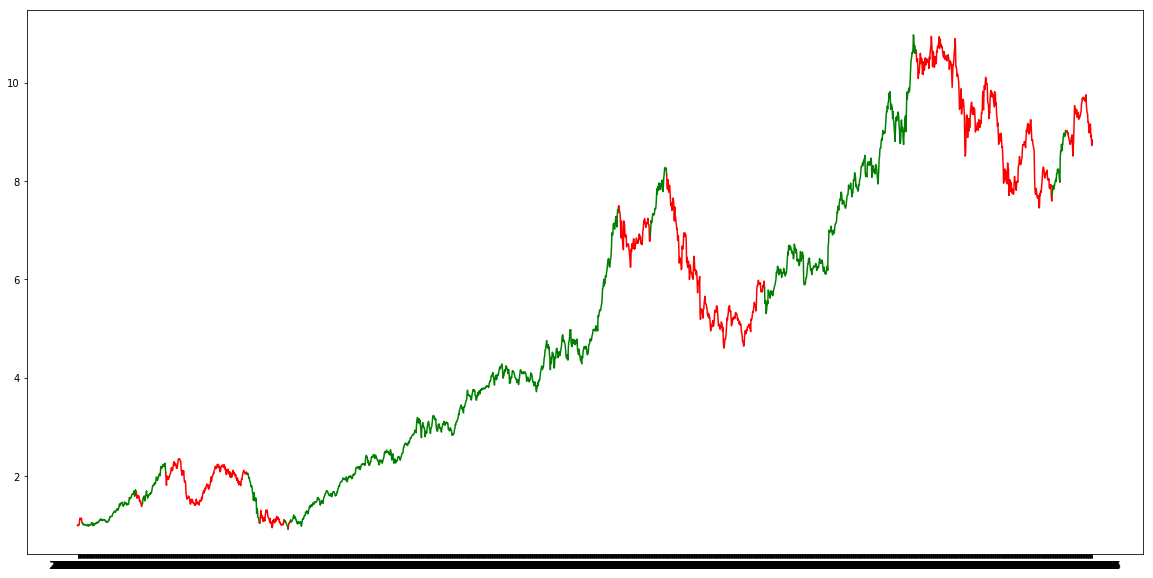

In [75]:
stock_titles = ['AAPL']

for stock_title in stock_titles:

    stock_data = data_new[
        data_new['Stockname'] == stock_title
    ].sort_values(by='Date', ascending = True).reset_index(drop=True)
    
    normalize = stock_data.loc[0]['Close']
    stock_data['Close'] = stock_data['Close'] / normalize

    colors = {
        1: 'green',
        0: 'red',
        -1: 'grey'
    }

    fig = plt.figure(figsize=(20,10))
    
    print( stock_title )
    
    trend = -10
    x, y = [], []
    
    for index, row in stock_data.iterrows():
        if trend == -10:
            trend = row['Int_trend']
            
        x.append( row["Date"] )
        y.append( row["Close"] )
            
        if trend != row['Int_trend']:
            plt.plot( x, y, color=colors[trend] )
            x, y = [ row["Date"] ], [ row["Close"] ]
            trend = row['Int_trend']
            
    plt.show()
    #fig.savefig('input_data/{}'.format(stock_title))

#  Подготовим данные для модели

In [2]:
data_new = pd.read_csv('data_new.csv')

In [3]:
# сделаем динамичное окно размера window_size

rolling_data = []

for stock in ['Example', 'F', 'MA', '1', 'AAPL', 'NKE', 'CMCSA', 'GILD', 'SBUX',
       'MO', 'INTC', 'UNP', 'KO', 'PFE', 'BMY', 'CSCO', 'DHR', 'CELG',
       'celg', 'MSFT', 'HAL', 'LOW', 'CVS', 'CL', 'DIS', 'VZ', 'T', 'WCF',
       'WFC', 'USB', 'SO', 'GE', 'QCOM', 'HD', 'DOW', 'AMZN', 'BK', 'TWX',
       'MRK', 'PCLN', 'MCD', 'EMR', 'HON', 'BIIB', 'WMT', 'DD', 'OXY',
       'JPM', 'LLU', 'LLY', 'COST', 'MON', 'MDT', 'RTN', 'UNH', 'BAC',
       'NEE', 'COP', 'TGT', 'DUK', 'MET', 'CAT', 'EXC', 'UTX', 'PEP',
       'SLB', 'PG', 'JNJ', 'MS', 'CVX', 'GD', 'UPS', 'XOM', 'COF', 'MMM',
       'BA', 'SPG', 'LMT', 'IBM', 'FDX', 'BLK', 'GS', 'GOOGL', 'C',
       'BOLL', 'CPRI', 'DLGS', 'TLIT', 'A2', 'TRN', 'SRG', 'MAP', 'GL9',
       'EDP', 'PLOF', 'JMT', 'SABE', 'ISP', 'RYA', 'FCHA', 'RECI', 'KPN',
       'ENEI', 'GRLS', 'BKT', 'IBE', 'GLPG', 'REE', 'WDIG', 'CNAT',
       'RELN', 'SAN', 'ITX', 'AD', 'GETP', 'IFXGn', 'ZODC', 'GALP',
       'HUH1V', 'SATG', 'STERV', 'FPEG', 'KNEBV', 'AZMT', 'VLOF', 'STM',
       'PTNL', 'DTEGn', 'AMEAS', 'UTDI', 'QIA', 'AEGN', 'ABE', 'AMS',
       'MDBI', 'BBVA', 'RUBF', 'FER', 'DWNG', 'DUEG', 'TEF', 'SESFd',
       'CLN', 'UPM', 'RXL', 'EMII', 'TENR', 'ELE', 'BALDb', 'UBI',
       'FNTGn', 'ETL', 'ELISA', 'ENAG', 'SKG', 'VIS', 'KSP', 'GTO', 'TL5',
       'INGC', 'ORNBV', 'MRON', 'FREG', 'SAF', 'TNET', 'PRY', 'SCOR',
       'LDOF', 'BION', 'AALB', 'KYGa', 'ASMI', 'SY1G', 'ORAN', 'NOKIA',
       'VOPA', 'ATL', 'DPWGn', 'SAMPO', 'AIR', 'WLSNc', 'LHAG', 'BOK',
       'DAST', 'UNc', 'REP', 'ASML', 'UBIP', 'DEQGn', 'JCDX', 'CNPP',
       'WRT1V', 'FORTUM', 'SOWG', 'G1AG', 'INGA', 'PPB', 'NESTE', 'SCAb',
       'LEGD', 'PSMGn', 'NRE1V', 'ENI', 'SDFGn', 'ANDR', 'LUX', 'SGREN',
       'CAGR', 'ABBN', 'KINDsdb', 'NIBEb', 'BOSN', 'TEMN', 'RDSa', 'SBMO',
       'EKTAb', 'AXAF', 'PHG', 'FTI', 'CRH', 'VIV', 'ARLG', 'PROX',
       'GASI', 'COLR', 'ROCH', 'PUBP', 'UMI', 'CFR', 'LOGN', 'LAGA',
       'SPMI', 'ENGIE', 'GAS', 'HNRGn', 'EONGn', 'GXIG', 'LOIM', 'FMEG']:

    stock_data = data_new[data_new['Stockname'] == stock][['Open','High','Low','Close','Volume','Int_trend']].copy()

    window_size = 50

    for i in range(window_size, len(stock_data)):
        window_values = stock_data[['Open','High','Low','Close','Volume']][i-window_size:i].values.copy()
        window_trend = stock_data['Int_trend'].values[-1]
        for i in range(window_size):
            for k in range(5):
                window_values[window_size-i-1][k] = window_values[window_size-i-1][k] / window_values[0][k]
        rolling_data.append({'trend': window_trend,
                             'features': window_values[1:]})
    print(stock)

Example
F
MA
1
AAPL
NKE
CMCSA
GILD
SBUX
MO
INTC
UNP
KO
PFE
BMY
CSCO
DHR
CELG
celg
MSFT
HAL
LOW
CVS
CL
DIS
VZ
T
WCF
WFC
USB
SO
GE
QCOM
HD
DOW
AMZN
BK
TWX
MRK
PCLN
MCD
EMR
HON
BIIB
WMT
DD
OXY
JPM
LLU
LLY
COST
MON
MDT
RTN
UNH
BAC
NEE
COP
TGT
DUK
MET
CAT
EXC
UTX
PEP
SLB
PG
JNJ
MS
CVX
GD
UPS
XOM
COF
MMM
BA
SPG
LMT
IBM
FDX
BLK
GS
GOOGL
C
BOLL
CPRI
DLGS
TLIT
A2
TRN
SRG
MAP
GL9
EDP
PLOF
JMT
SABE
ISP
RYA
FCHA
RECI
KPN
ENEI
GRLS
BKT
IBE
GLPG
REE
WDIG
CNAT
RELN
SAN
ITX
AD
GETP
IFXGn
ZODC
GALP
HUH1V
SATG
STERV
FPEG
KNEBV
AZMT
VLOF
STM
PTNL
DTEGn
AMEAS
UTDI
QIA
AEGN
ABE
AMS
MDBI
BBVA
RUBF
FER
DWNG
DUEG
TEF
SESFd
CLN
UPM
RXL
EMII
TENR
ELE
BALDb
UBI
FNTGn
ETL
ELISA
ENAG
SKG
VIS
KSP
GTO
TL5
INGC
ORNBV
MRON
FREG
SAF
TNET
PRY
SCOR
LDOF
BION
AALB
KYGa
ASMI
SY1G
ORAN
NOKIA
VOPA
ATL
DPWGn
SAMPO
AIR
WLSNc
LHAG
BOK
DAST
UNc
REP
ASML
UBIP
DEQGn
JCDX
CNPP
WRT1V
FORTUM
SOWG
G1AG
INGA
PPB
NESTE
SCAb
LEGD
PSMGn
NRE1V
ENI
SDFGn
ANDR
LUX
SGREN
CAGR
ABBN
KINDsdb
NIBEb
BOSN
TEMN
RDSa
SBMO
EKTAb
AXAF
PHG
FTI
CRH
VIV
A

# Обучение

In [ ]:
X_dim = (window_size - 1) * 5 #  сколько дней в окне
y_dim = 1 # потому что либо есть тренд, либо его нет
h_dim = 200 # сколько блоков генерируем

batch_size = 128

Z_dim = 20

save_steps=1000


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

with tf.device('/gpu:0'):
    """ Discriminator Net model """
    X = tf.placeholder(tf.float32, shape=[None, X_dim])
    y = tf.placeholder(tf.float32, shape=[None, y_dim])

    D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
    D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

    D_W2 = tf.Variable(xavier_init([h_dim, 1]))
    D_b2 = tf.Variable(tf.zeros(shape=[1]))

    theta_D = [D_W1, D_W2, D_b1, D_b2]


    def discriminator(x, y):
        inputs = tf.concat(axis=1, values=[x, y])
        D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
        D_logit = tf.matmul(D_h1, D_W2) + D_b2
        D_prob = tf.nn.sigmoid(D_logit)

        return D_prob, D_logit


    """ Generator Net model """
    Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

    G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
    G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

    G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
    G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

    theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=0.000055).minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')
    
def random_batch(batch_size=256):
    x_batch = []
    y_batch = []
    step = 0
    while step < batch_size:
        batch = []
        t = random.choice(rolling_data)
        for i in t['features']:
            for j in i:
                batch.append(j)
        x_batch.append(batch)
        y_batch.append([t['trend']])
        step = step + 1
    return x_batch, y_batch

i = 0

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

for it in range(1000000):
    if (it+1) % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.reshape(np.random.randint(1,2,n_sample*y_dim),(n_sample, 1))

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        i += 1

    X_mb, y_mb = random_batch(batch_size)

    Z_sample = sample_Z(batch_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if (it+1) % 100 == 0:
        print('Step={} D_loss={}, G_loss={}'.format(it, D_loss_curr, G_loss_curr))
        
    if (it+1) % save_steps == 0:
        saver.save(sess, './models/gan.ckpt', it)

# Проверка обучения

In [45]:
good = total_number = 0

for i in range(5000):#range(len(rolling_data)):
    trend_prob = sess.run(D_real,
                             feed_dict={X: np.array( rolling_data[i]['features'] ).reshape( (1, X_dim) ).astype(np.float32),
                                        y: np.array( [np.float32(1.)] ).reshape( (1, y_dim) )}
                            )
    no_trend_prob = sess.run(D_real,
                             feed_dict={X: np.array( rolling_data[i]['features'] ).reshape( (1, X_dim) ).astype(np.float32),
                                        y: np.array( [np.float32(0.)] ).reshape( (1, y_dim) )}
                            )
    trend = 1 if trend_prob > no_trend_prob else 0
    
    if trend == rolling_data[i]['trend']:
        good = good + 1
    
    total_number = total_number + 1
    
print ( good, total_number, good / total_number )

3159 5000 0.6318


# Протестируем на какой-нибудь бумаге

In [40]:
data_new['Stockname'].unique()

array(['Example', 'F', 'MA', '1', 'AAPL', 'NKE', 'CMCSA', 'GILD', 'SBUX',
       'MO', 'INTC', 'UNP', 'KO', 'PFE', 'BMY', 'CSCO', 'DHR', 'CELG',
       'celg', 'MSFT', 'HAL', 'LOW', 'CVS', 'CL', 'DIS', 'VZ', 'T', 'WCF',
       'WFC', 'USB', 'SO', 'GE', 'QCOM', 'HD', 'DOW', 'AMZN', 'BK', 'TWX',
       'MRK', 'PCLN', 'MCD', 'EMR', 'HON', 'BIIB', 'WMT', 'DD', 'OXY',
       'JPM', 'LLU', 'LLY', 'COST', 'MON', 'MDT', 'RTN', 'UNH', 'BAC',
       'NEE', 'COP', 'TGT', 'DUK', 'MET', 'CAT', 'EXC', 'UTX', 'PEP',
       'SLB', 'PG', 'JNJ', 'MS', 'CVX', 'GD', 'UPS', 'XOM', 'COF', 'MMM',
       'BA', 'SPG', 'LMT', 'IBM', 'FDX', 'BLK', 'GS', 'GOOGL', 'C',
       'BOLL', 'CPRI', 'DLGS', 'TLIT', 'A2', 'TRN', 'SRG', 'MAP', 'GL9',
       'EDP', 'PLOF', 'JMT', 'SABE', 'ISP', 'RYA', 'FCHA', 'RECI', 'KPN',
       'ENEI', 'GRLS', 'BKT', 'IBE', 'GLPG', 'REE', 'WDIG', 'CNAT',
       'RELN', 'SAN', 'ITX', 'AD', 'GETP', 'IFXGn', 'ZODC', 'GALP',
       'HUH1V', 'SATG', 'STERV', 'FPEG', 'KNEBV', 'AZMT', 'VLOF', 'S

AAPL


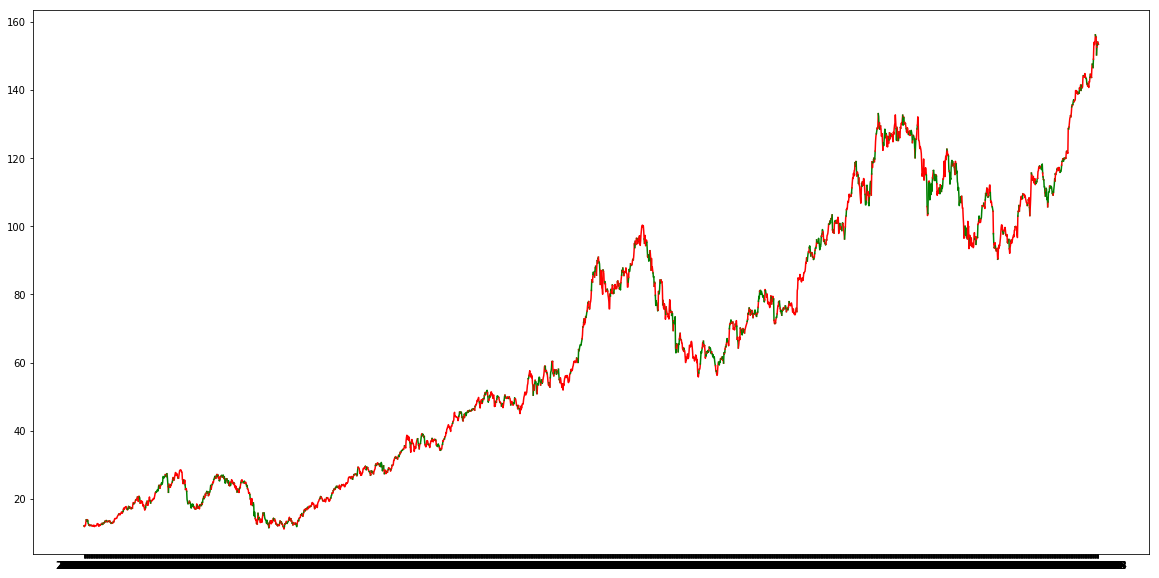

In [47]:
stock_titles = ['AAPL']

for stock_title in stock_titles:

    stock_data = data_new[
        data_new['Stockname'] == stock_title
    ].sort_values(by='Date', ascending = True).reset_index(drop=True)

    colors = {
        1: 'green',
        0: 'red',
        -1: 'grey'
    }

    fig = plt.figure(figsize=(20,10))
    
    print( stock_title )
    
    trend = -10
    x_, y_ = [], []
    
    for index, row in stock_data.iterrows():
        trend_prob = sess.run(D_real,
                             feed_dict={X: np.array( rolling_data[index+window_size-1]['features'] ).reshape( (1, X_dim) ).astype(np.float32),
                                        y: np.array( [np.float32(1.)] ).reshape( (1, y_dim) )}
                            )
        no_trend_prob = sess.run(D_real,
                                 feed_dict={X: np.array( rolling_data[index+window_size-1]['features'] ).reshape( (1, X_dim) ).astype(np.float32),
                                            y: np.array( [np.float32(0.)] ).reshape( (1, y_dim) )}
                                )
        cur_trend = 1 if trend_prob > no_trend_prob else 0
        
        if trend == -10:
            trend = cur_trend
            
        x_.append( row["Date"] )
        y_.append( row["Close"] )
            
        if trend != cur_trend:
            plt.plot( x_, y_, color=colors[trend] )
            x_, y_ = [ row["Date"] ], [ row["Close"] ]
            trend = cur_trend
            
    plt.show()